In [2]:
import os
import shutil
import numpy as np
import tensorflow as tf
import cv2
from tensorflow import keras
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout,Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

In [3]:
data_dir = r'C:\Major Project\cardiomyopathy-dataset'
print(data_dir)
# List of classes (subfolders)
classes = os.listdir(data_dir)
print(classes)

C:\Major Project\cardiomyopathy-dataset
['Normal', 'Sick']


In [4]:
# Dictionary to store the image paths by class
data = {cls: [] for cls in classes}
# Iterate through each class
for cls in classes:
    cls_path = os.path.join(data_dir, cls)
    # Skip files that are not directories
    if os.path.isdir(cls_path):
        # Recursively go through all subdirectories
        for root, dirs, files in os.walk(cls_path):
            # Add the full image paths to the dictionary
            data[cls].extend([os.path.join(root, file) for file in files])

In [5]:
# Split the data into training, validation, and test sets for each class
train_data, validation_data, test_data = {}, {}, {}
for cls, images in data.items():
    # Split the data into training (70%) and test (30%) sets
    train_images, test_images = train_test_split(images, test_size=0.3, random_state=42)

    # Split the test data into test (10%) and validation (20%) sets
    validation_images, test_images = train_test_split(test_images, test_size=0.33, random_state=42)

    # Store the image paths in the appropriate dictionaries
    train_data[cls] = train_images
    validation_data[cls] = validation_images
    test_data[cls] = test_images


In [6]:
# Check the data distribution
for cls in classes:
    print(f"Class: {cls}")
    print(f"Training data size: {len(train_data[cls])}")
    print(f"Test data size: {len(test_data[cls])}")
    print(f"Validation data size: {len(validation_data[cls])}")
    print("---------------------------")

Class: Normal
Training data size: 26294
Test data size: 3720
Validation data size: 7550
---------------------------
Class: Sick
Training data size: 15298
Test data size: 2164
Validation data size: 4393
---------------------------


In [7]:
# Full paths of the training, validation, and test directories
train_data_dir = r'C:\Major Project\train_test_split\train_data'
test_data_dir = r'C:\Major Project\train_test_split\test_data'
validation_data_dir = r'C:\Major Project\train_test_split\validation_data'
print(train_data_dir)
print(test_data_dir)
print(validation_data_dir)

C:\Major Project\train_test_split\train_data
C:\Major Project\train_test_split\test_data
C:\Major Project\train_test_split\validation_data


In [8]:
# Copy the images into the appropriate directories
for cls, paths in train_data.items():
    cls_dir = os.path.join(train_data_dir, cls)
    os.makedirs(cls_dir, exist_ok=True)
    for path in paths:
        shutil.copy(path, cls_dir)

for cls, paths in test_data.items():
    cls_dir = os.path.join(test_data_dir, cls)
    os.makedirs(cls_dir, exist_ok=True)
    for path in paths:
        shutil.copy(path, cls_dir)

for cls, paths in validation_data.items():
    cls_dir = os.path.join(validation_data_dir, cls)
    os.makedirs(cls_dir, exist_ok=True)
    for path in paths:
        shutil.copy(path, cls_dir)

In [8]:
# Model parameters
input_shape = (150, 150, 3)
batch_size = 64
epochs = 10
learning_rate = 0.001
dropout_rate = 0.5

In [9]:
# Data augmentation to enrich the training set
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(input_shape[0], input_shape[1]),
    batch_size=batch_size,
    class_mode='binary'
)

validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(input_shape[0], input_shape[1]),
    batch_size=batch_size,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(input_shape[0], input_shape[1]),
    batch_size=batch_size,
    class_mode='binary'
)

Found 29911 images belonging to 2 classes.
Found 10374 images belonging to 2 classes.
Found 5495 images belonging to 2 classes.


In [10]:
# Define the CNN model correctly
model = Sequential([
    Input(shape=input_shape),  # Explicit input layer
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(dropout_rate),
    Dense(1, activation='sigmoid')
])

In [11]:
# Compile the model
optimizer = Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

In [12]:
# Training the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size
)

C:\Users\Dhanush\AppData\Roaming\Python\Python312\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 307s 654ms/step - accuracy: 0.6291 - loss: 0.6436 - val_accuracy: 0.8328 - val_loss: 0.3528
Epoch 2/10
  1/467 ━━━━━━━━━━━━━━━━━━━━ 3:27 444ms/step - accuracy: 0.7969 - loss: 0.4018

C:\Users\Dhanush\AppData\Roaming\Python\Python312\site-packages\keras\src\trainers\epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


467/467 ━━━━━━━━━━━━━━━━━━━━ 26s 54ms/step - accuracy: 0.7969 - loss: 0.4018 - val_accuracy: 0.8296 - val_loss: 0.3530
Epoch 3/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 308s 658ms/step - accuracy: 0.8251 - loss: 0.3714 - val_accuracy: 0.8963 - val_loss: 0.2473
Epoch 4/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 25s 53ms/step - accuracy: 0.8750 - loss: 0.2558 - val_accuracy: 0.8957 - val_loss: 0.2486
Epoch 5/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 304s 652ms/step - accuracy: 0.8829 - loss: 0.2622 - val_accuracy: 0.9191 - val_loss: 0.1916
Epoch 6/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 26s 55ms/step - accuracy: 0.9375 - loss: 0.2102 - val_accuracy: 0.9193 - val_loss: 0.1921
Epoch 7/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 304s 651ms/step - accuracy: 0.8995 - loss: 0.2182 - val_accuracy: 0.9247 - val_loss: 0.1720
Epoch 8/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 25s 53ms/step - accuracy: 0.8594 - loss: 0.2816 - val_accuracy: 0.9241 - val_loss: 0.1724
Epoch 9/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 305s 652ms/step - accuracy: 0.9117 - loss: 0.1903 - val

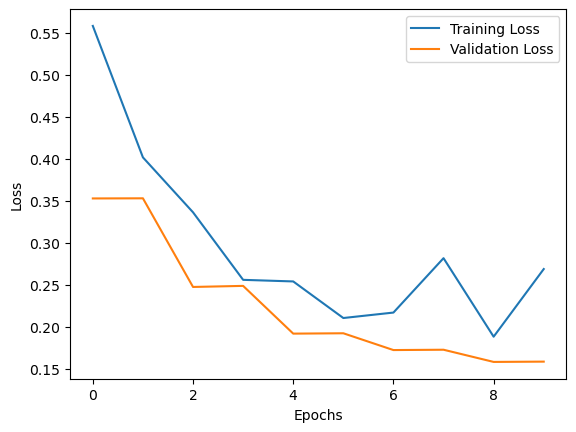

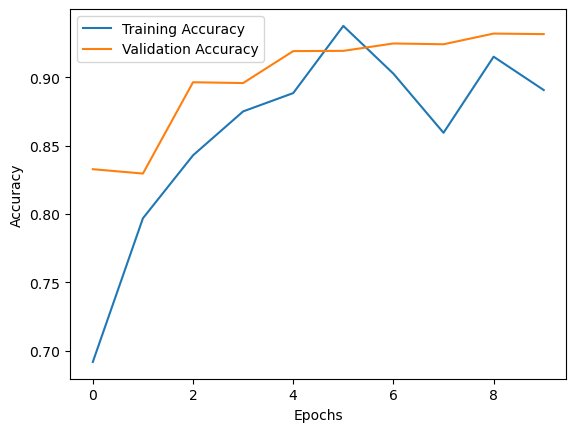

In [13]:
# Displaying the learning curves
import matplotlib.pyplot as plt

# Loss curves for training and validation sets
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Accuracy curves for training and validation sets
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [14]:
# Save the model
model.save(r"C:\Major Project\model\heart_model.h5")

In [15]:
# Load the model for testing
model = load_model(r"C:\Major Project\model\heart_model.h5")

In [16]:
# Evaluate the model on the test set
evaluation = model.evaluate(test_generator)

# Display the metrics
print(f"\nModel Evaluation on the Test Set:")
print(f"Loss: {evaluation[0]}")
print(f"Accuracy: {evaluation[1]}")

86/86 ━━━━━━━━━━━━━━━━━━━━ 15s 166ms/step - accuracy: 0.9228 - loss: 0.1712

Model Evaluation on the Test Set:
Loss: 0.1759156882762909
Accuracy: 0.9217470288276672


In [17]:
# Prediction on a specific example
sample_image_path = 'C:/Major Project/train_test_split/validation_data/Sick/img0018-20.7061.jpg'
img = keras.preprocessing.image.load_img(sample_image_path, target_size=(150, 150))
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

# Normalize the image
img_array /= 255.0

# Prediction
prediction = model.predict(img_array)

# Display the prediction
if prediction[0] > 0.5:
    print("The subject is sick.")
else:
    print("The subject is healthy.")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
The subject is sick.


In [21]:
# Find Most Similar Healthy and Sick Heart Image
def find_most_similar(test_image_path, compare_dir):
    test_img = cv2.imread(test_image_path)
    test_img = cv2.resize(test_img, (150, 150))
    test_img_gray = cv2.cvtColor(test_img, cv2.COLOR_BGR2GRAY)

    best_match = None
    best_similarity = -1
    best_image_path = ""

    for img_name in os.listdir(compare_dir):
        img_path = os.path.join(compare_dir, img_name)
        img = cv2.imread(img_path)
        img = cv2.resize(img, (150, 150))
        img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        similarity = ssim(test_img_gray, img_gray)

        if similarity > best_similarity:
            best_similarity = similarity
            best_match = img
            best_image_path = img_path

    return best_match, best_similarity * 100, best_image_path

In [22]:
# Compare with Healthy and Sick Images
healthy_img, healthy_sim, healthy_path = find_most_similar(sample_image_path, f"{test_data_dir}/Normal")
sick_img, sick_sim, sick_path = find_most_similar(sample_image_path, f"{test_data_dir}/Sick")

print(f"\nMost Similar Healthy Image: {healthy_path} (Similarity: {healthy_sim:.2f}%)")
print(f"Most Similar Sick Image: {sick_path} (Similarity: {sick_sim:.2f}%)")


Most Similar Healthy Image: C:\Major Project\train_test_split\test_data/Normal\img0039-13.4134.jpg (Similarity: 18.85%)
Most Similar Sick Image: C:\Major Project\train_test_split\test_data/Sick\img0015-20.7061.jpg (Similarity: 95.27%)


Text(0.5, 1.0, 'Test Image')

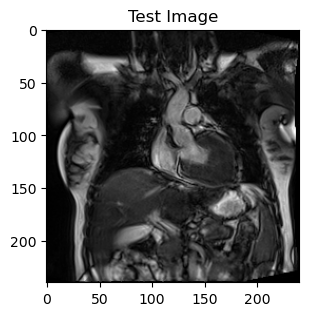

In [23]:
# Display images
plt.figure(figsize=(15, 5))

plt.subplot(1, 4, 1)
plt.imshow(cv2.cvtColor(cv2.imread(sample_image_path), cv2.COLOR_BGR2RGB))
plt.title("Test Image")

Text(0.5, 1.0, 'Most Similar Healthy\n18.85% Match')

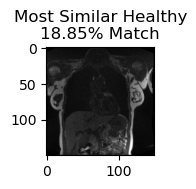

In [24]:
plt.subplot(1, 4, 2)
plt.imshow(cv2.cvtColor(healthy_img, cv2.COLOR_BGR2RGB))
plt.title(f"Most Similar Healthy\n{healthy_sim:.2f}% Match")

Text(0.5, 1.0, 'Most Similar Sick\n95.27% Match')

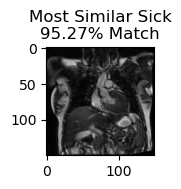

In [25]:
plt.subplot(1, 4, 3)
plt.imshow(cv2.cvtColor(sick_img, cv2.COLOR_BGR2RGB))
plt.title(f"Most Similar Sick\n{sick_sim:.2f}% Match")

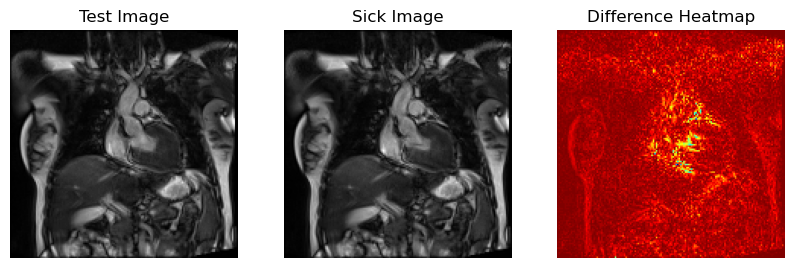

In [26]:
# Load test and sick images
test_img = cv2.imread(sample_image_path, cv2.IMREAD_GRAYSCALE)  # Convert to grayscale
sick_img = cv2.cvtColor(sick_img, cv2.COLOR_BGR2GRAY) if len(sick_img.shape) == 3 else sick_img

# Resize test image to match sick_img dimensions
test_img = cv2.resize(test_img, (sick_img.shape[1], sick_img.shape[0]))

# Compute absolute difference
diff = cv2.absdiff(test_img, sick_img)

# Normalize for better contrast
diff = cv2.normalize(diff, None, 0, 255, cv2.NORM_MINMAX)
# Apply a colormap for better visualization
diff_colored = cv2.applyColorMap(diff.astype(np.uint8), cv2.COLORMAP_JET)

# Display results
plt.figure(figsize=(10, 4))
# Show original test image
plt.subplot(1, 3, 1)
plt.imshow(test_img, cmap="gray")
plt.title("Test Image")
plt.axis("off")
# Show sick image
plt.subplot(1, 3, 2)
plt.imshow(sick_img, cmap="gray")
plt.title("Sick Image")
plt.axis("off")

# Show heatmap difference
plt.subplot(1, 3, 3)
plt.imshow(diff_colored)
plt.title("Difference Heatmap")
plt.axis("off")

plt.show()
